In [6]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, plot_2d_slice, turbulent_power_specta, plot_timeseries
from superfv.initial_conditions import decaying_isotropic_turbulence

In [7]:
def turbulent_crossing_time(sim):
    idx = sim.variable_index_map
    w = sim.snapshots[0]["w"]
    vx = w[idx("vx")]
    vy = w[idx("vy")]
    v = np.sqrt(vx**2 + vy**2)
    crossing_time = 1 / np.std(v)
    return crossing_time

In [ ]:
seed = 1
N = 64
T = [0.08, 0.16, 0.24]

PAD = {"rho": (0, None)}

configs = {
    "p0": dict(p=0),
    "MUSCL-Hancock": dict(p=1, MUSCL=True, MUSCL_limiter="PP2D"),
    "ZS3": dict(p=3, ZS=True, GL=True, lazy_primitives="adaptive", PAD=PAD),
    "MM3": dict(
        p=3,
        MOOD=True,
        lazy_primitives="adaptive",
        limiting_vars=("rho", "vx", "vy"),
        PAD=PAD,
        blend=True,
    ),
}

In [9]:
sims = {}
for name, config in configs.items():
    print(f"- - - - - Running simulation: {name} - - - - -")
    sim = EulerSolver(
        ic=partial(decaying_isotropic_turbulence, seed=seed, M=10, slope=-5 / 3),
        isothermal=True,
        nx=N,
        ny=N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            allow_overshoot=True,
            muscl_hancock=config.get("MUSCL", False),
            log_freq=20,
        )
        sim.print_timings()
        sims[name] = sim
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

- - - - - Running simulation: MM3 - - - - -
Step #309 @ t=2.41e-01 | dt=1.50e-03 | min(rho)=2.47e-02, min(P)=2.47e-02 | E_cons=5.82e-11 | (ran in 35.43s)
Routine                      # of calls  Total time (s) % time
---------------------------  ----------  --------------  ------
wall                                  1           35.43   100.0
take_step                           309           35.26    99.5
compute_dt                          309            0.04     0.1
apply_bc                           1858            0.34     1.0
riemann_solver                     3708            5.48    15.5
shock_detector                      931            8.53    24.1
zhang_shu_limiter                     0               -       -
MOOD_loop                           927           14.30    40.4
      detect_troubled_cells         927            6.62    18.7
      revise_fluxes                 927            7.66    21.6
snapshot                              4            0.13     0.4
minisnapshot   

/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.08 not exactly matched in mesh; using nearest: 0.0803865
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.08 not exactly matched in mesh; using nearest: 0.0803865
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.16 not exactly matched in mesh; using nearest: 0.160832
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.16 not exactly matched in mesh; using nearest: 0.160832
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.24 not exactly matched in mesh; using nearest: 0.241234
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.24 not exactly matched in m

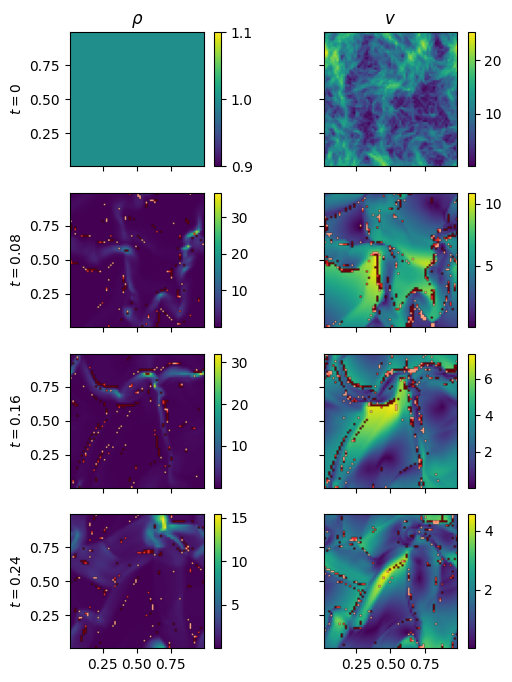

In [10]:
sim = sims["MM3"]

fig, axs = plt.subplots(
    len(T) + 1, 2, sharex=True, sharey=True, figsize=(6, (len(T) + 1) * 2)
)

axs[0, 0].set_title(r"$\rho$")
axs[0, 1].set_title(r"$v$")

for i, t in enumerate([0] + T):
    axs[i, 0].set_ylabel(f"$t={t}$")
    plot_2d_slice(
        sim,
        axs[i, 0],
        "rho",
        cell_averaged=True,
        colorbar=True,
        t=t,
        overlay_troubles=True,
        troubles_alpha=1.0,
    )
    plot_2d_slice(
        sim,
        axs[i, 1],
        "v",
        cell_averaged=True,
        colorbar=True,
        t=t,
        overlay_troubles=True,
        troubles_alpha=1.0,
    )

KeyError: 'MUSCL-Hancock'

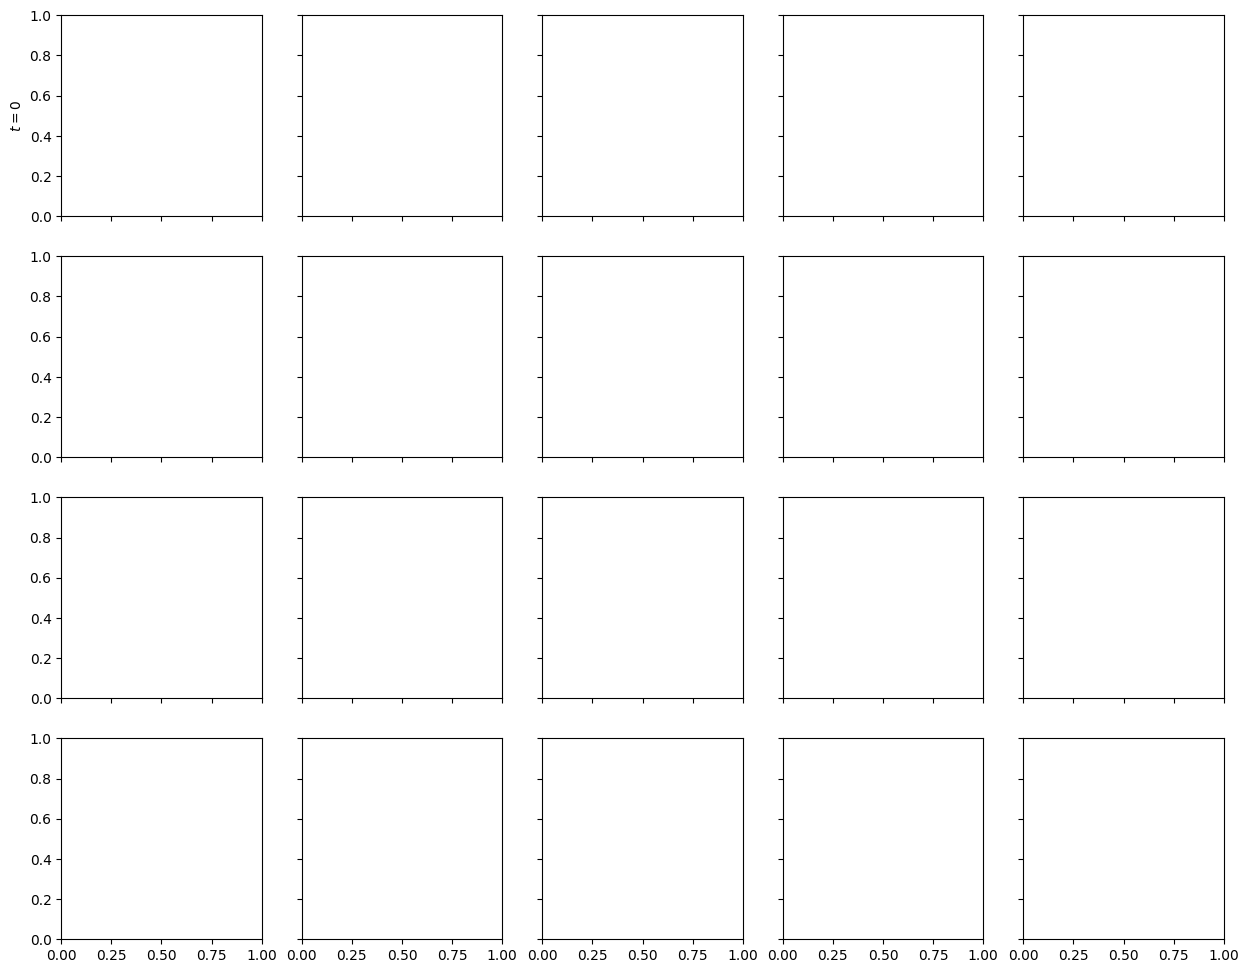

In [11]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(15, 12))

for i, t in enumerate([0, *T]):
    axs[i, 0].set_ylabel(f"$t={t}$")

    for j, sim_name in enumerate(["MUSCL-Hancock", "ZS3", "MM3", "ZS7", "MM7"]):
        sim = sims[sim_name]

        # plot_2d_slice(sim, axs[i, j], "rho", t=t, func=lambda x: np.log10(np.maximum(x, 1e-15)), vmin=-3, vmax=3)
        plot_2d_slice(sim, axs[i, j], "v", t=t)

(<matplotlib.image.AxesImage at 0x11795f950>,
 <matplotlib.colorbar.Colorbar at 0x11795c6b0>)

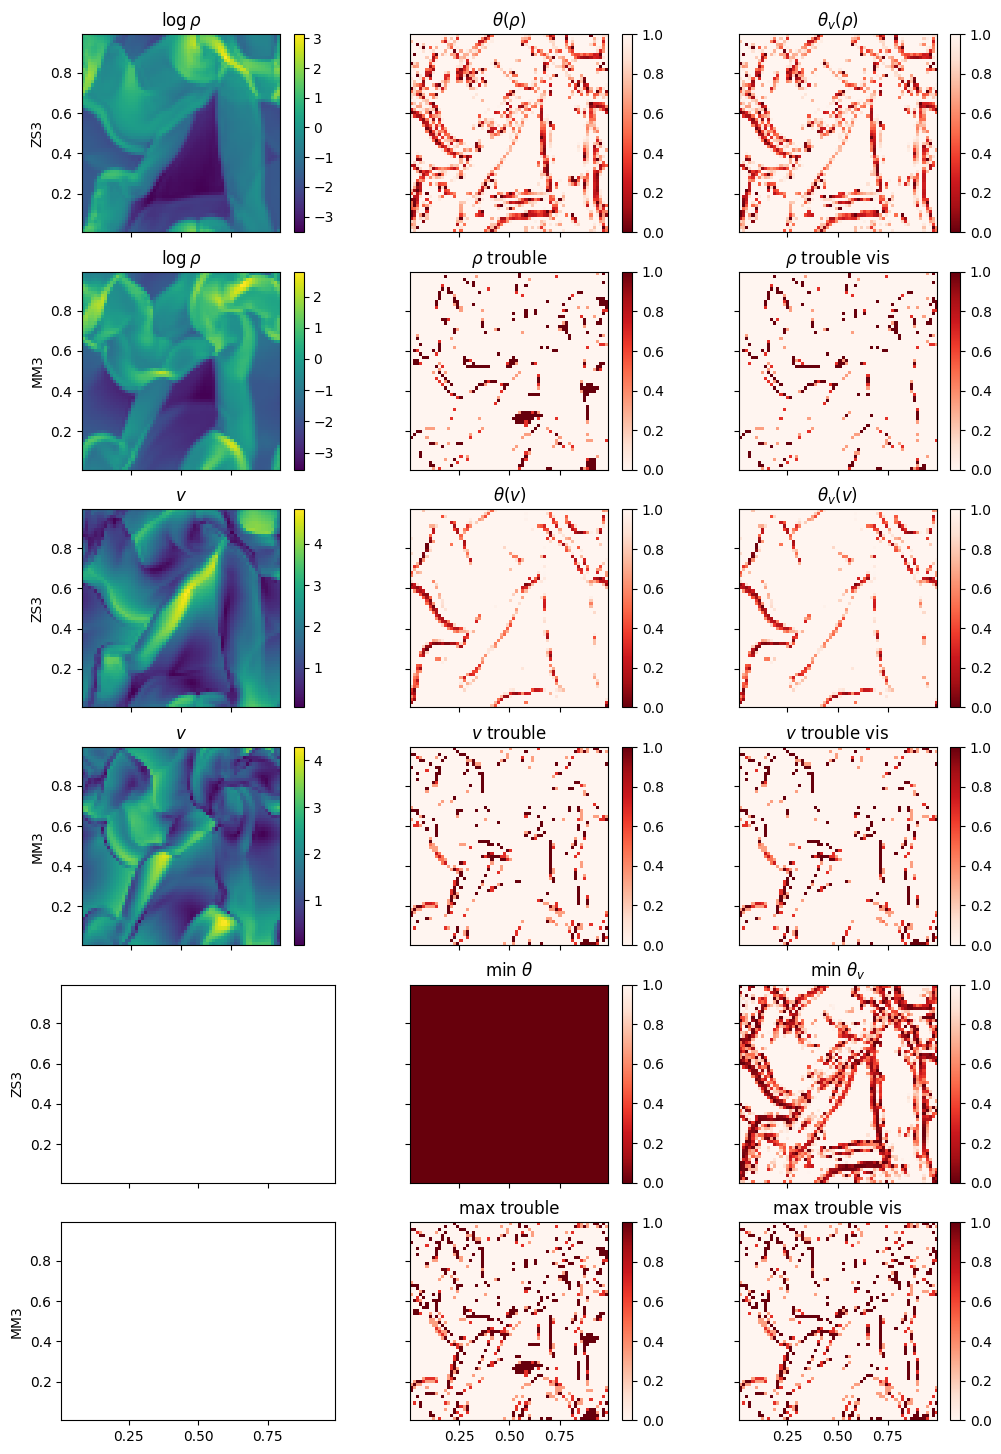

In [ ]:
sim1 = sims["ZS3"]
sim2 = sims["MM3"]

fig, axs = plt.subplots(6, 3, sharex=True, sharey=True, figsize=(12, 18))

axs[0, 0].set_ylabel("ZS3")
axs[0, 0].set_title(r"$\log \rho$")
axs[0, 1].set_title(r"$\theta(\rho)$")
axs[0, 2].set_title(r"$\theta_v(\rho)$")

axs[1, 0].set_ylabel("MM3")
axs[1, 0].set_title(r"$\log \rho$")
axs[1, 1].set_title(r"$\rho$ trouble")
axs[1, 2].set_title(r"$\rho$ trouble vis")

axs[2, 0].set_ylabel("ZS3")
axs[2, 0].set_title(r"$v$")
axs[2, 1].set_title(r"$\theta(v)$")
axs[2, 2].set_title(r"$\theta_v(v)$")

axs[3, 0].set_ylabel("MM3")
axs[3, 0].set_title(r"$v$")
axs[3, 1].set_title(r"$v$ trouble")
axs[3, 2].set_title(r"$v$ trouble vis")

axs[4, 0].set_ylabel("ZS3")
axs[4, 1].set_title(r"min $\theta$")
axs[4, 2].set_title(r"min $\theta_v$")

axs[5, 0].set_ylabel("MM3")
axs[5, 1].set_title(r"max trouble")
axs[5, 2].set_title(r"max trouble vis")

style = dict(cell_averaged=True, colorbar=True)
theta_style = dict(theta=True, cmap="Reds_r", vmin=0, vmax=1, colorbar=True)
trouble_style = dict(troubles=True, cmap="Reds", vmin=0, vmax=1, colorbar=True)

plot_2d_slice(sim1, axs[0, 0], "rho", func=lambda x: np.log(x), **style)
plot_2d_slice(sim1, axs[0, 1], "rho", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[0, 2], "rho", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[1, 0], "rho", func=lambda x: np.log(x), **style)
plot_2d_slice(sim2, axs[1, 1], "rho", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[1, 2], "rho", visualization=True, **trouble_style)

plot_2d_slice(sim1, axs[2, 0], "v", **style)
plot_2d_slice(sim1, axs[2, 1], "v", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[2, 2], "v", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[3, 0], "v", **style)
plot_2d_slice(sim2, axs[3, 1], "v", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[3, 2], "v", visualization=True, **trouble_style)

plot_2d_slice(sim1, axs[4, 1], "min", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[4, 2], "min", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[5, 1], "max", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[5, 2], "max", visualization=True, **trouble_style)

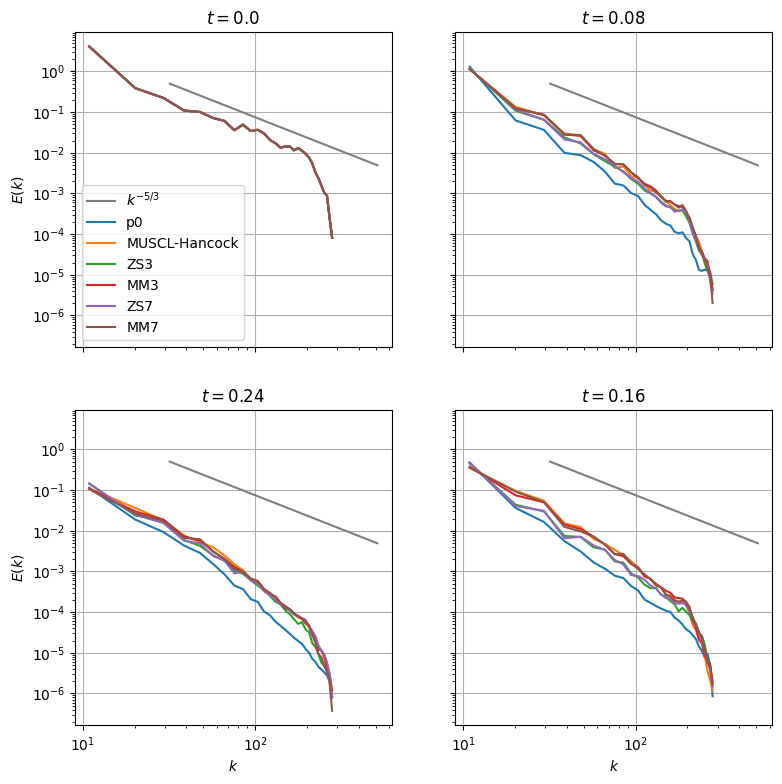

In [ ]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 9))
axs[1, 0].set_xlabel(r"$k$")
axs[1, 1].set_xlabel(r"$k$")
axs[0, 0].set_ylabel(r"$E(k)$")
axs[1, 0].set_ylabel(r"$E(k)$")
axs[0, 0].set_xscale("log")
axs[0, 0].set_yscale("log")

for (k, t), (i, j) in zip(enumerate([0.0, *T]), [(0, 0), (0, 1), (1, 1), (1, 0)]):
    axs[i, j].set_title(f"$t={t}$")
    axs[i, j].grid()
    axs[i, j].plot(
        [32, 512],
        [5e-1, 5e-1 * (512 / 32) ** (-5 / 3)],
        label=r"$k^{-5/3}$",
        color="gray",
    )

    for name, sim in sims.items():
        w = sim.snapshots[k]["w"]
        k_centers, E_k = turbulent_power_specta(
            sim.xp, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
        )

        axs[i, j].plot(
            k_centers, E_k, marker="none", mfc="none", linestyle="-", label=name
        )

axs[0, 0].legend()

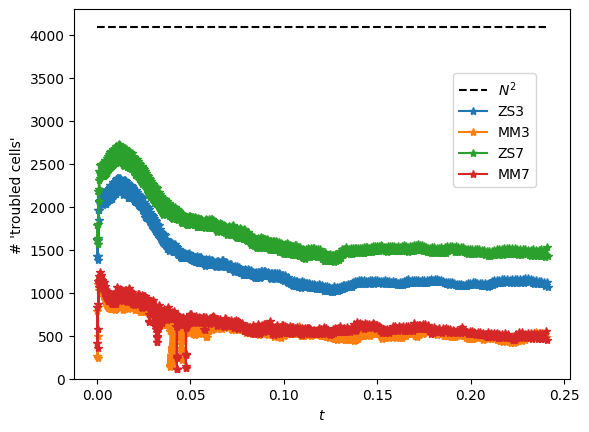

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim(0, 1.05 * N**2)

ax.set_xlabel(r"$t$")
ax.set_ylabel("# 'troubled cells'")

ax.plot([0, T[-1]], [N**2, N**2], "k--", label=r"$N^2$")
plot_timeseries(
    sims["ZS3"],
    ax,
    "max",
    one_minus_theta=True,
    visualization=True,
    label="ZS3",
    marker="*",
)
plot_timeseries(
    sims["MM3"], ax, "max", troubles=True, visualization=True, label="MM3", marker="*"
)
plot_timeseries(
    sims["ZS7"],
    ax,
    "max",
    one_minus_theta=True,
    visualization=True,
    label="ZS7",
    marker="*",
)
plot_timeseries(
    sims["MM7"], ax, "max", troubles=True, visualization=True, label="MM7", marker="*"
)

ax.legend(bbox_to_anchor=(0.75, 0.5))

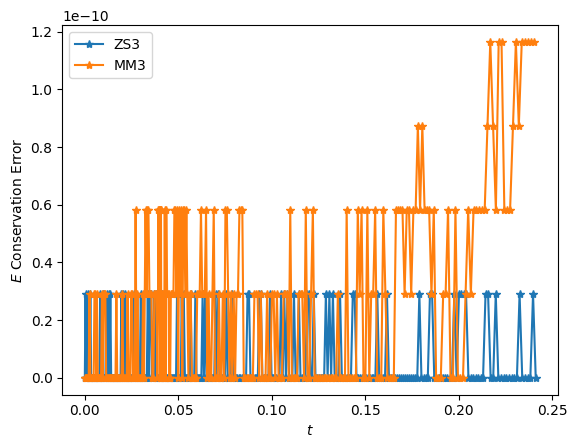

In [ ]:
fig, ax = plt.subplots()

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$E$ Conservation Error")

style = dict(marker="*")
plot_timeseries(sims["ZS3"], ax, "E_cons", label="ZS3", **style)
plot_timeseries(sims["MM3"], ax, "E_cons", label="MM3", **style)
# plot_timeseries(sims["ZS7"], ax, "E_cons", label="ZS7", **style)
# plot_timeseries(sims["MM7"], ax, "E_cons", label="MM7", **style)

ax.legend()

In [ ]:
v_xy = sims["p0"].snapshots[0]["w"][sims["p0"].variable_index_map("v")]
v = np.sqrt(np.sum(v_xy**2, axis=0))

1 / np.std(v)

np.float64(0.22899628247547316)